In [2]:
import torch
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from umap import UMAP
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from label_dict import protein_to_num_single_cells, protein_to_num_full
from tqdm import tqdm
from scipy.stats import ttest_ind, zscore, norm
from statsmodels.stats.weightstats import ztest as ztest
from skimage import io
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist
from seaborn import clustermap
from scipy.spatial.distance import squareform
cmap = cm.nipy_spectral

In [3]:
cmap = cm.nipy_spectral

def get_embeddings(features):
    scaled_features = StandardScaler().fit_transform(features.numpy())
    reducer = UMAP(init='random', random_state=42)
    embedding = reducer.fit_transform(scaled_features)
    return embedding

def plot_UMAP(df, labels, embedding, title):
    mat, labels = get_col_matrix(df, labels)
    plt.figure(figsize=(10,10), facecolor='white')
    plt.scatter(embedding[:, 0], 
                embedding[:, 1],
                s=0.1,
                label='All data',
                color='grey'
               )
    for i in range(mat.shape[1]):
        indices = np.where((mat[:, i] == 1) & (mat[:,:].sum(axis=1) == 1))[0]
        plt.scatter(embedding[indices, 0], 
                    embedding[indices, 1],
                    s=0.1,
                    label=labels[i],
                    color=cmap(i / mat.shape[1])
                   )

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title(title, fontsize=15)
    lgnd = plt.legend(bbox_to_anchor=(1,1), frameon=False)
    for h in lgnd.legendHandles:
        h._sizes = [30]

def get_col_matrix(df, labels):
    if len(labels) == 1:
        values = df[labels[0]]
        unique_values = sorted(np.unique(values))
        mat = np.zeros((len(df), len(unique_values)))
        for ind, value in enumerate(unique_values):
            mat[np.where(values == value)[0], ind] = 1
        columns = unique_values
    else:
        mat = df[sorted(labels)].values.astype(int)
        columns = sorted(labels)
    return mat, columns

def get_averaged_features(df, features, labels):
    mat, columns = get_col_matrix(df, labels)
    averaged_features = []
    for key in range(len(columns)):
        indices = np.where(mat[:,key])
        averaged_features.append(features[indices].mean(axis=0))
    averaged_features = torch.stack(averaged_features)
    return averaged_features, columns

def get_heirarchical_clustering(df, features, labels):
    averaged_features, columns = get_averaged_features(df, features, labels)
    distance_matrix = cosine_similarity(averaged_features, averaged_features)
    Z = linkage(distance_matrix)
    plt.figure(figsize=(20,5))
    dn = dendrogram(Z, labels = columns)
    plt.xticks(rotation=45)
    distance_matrix = distance_matrix[dn['leaves'], :][:, dn['leaves']]
    columns = dn['ivl']
    plt.figure(figsize=(10,10))
    plt.imshow(distance_matrix)
    plt.xticks(range(len(columns)), columns, rotation=90)
    plt.yticks(range(len(columns)), columns)
    return distance_matrix, columns

def get_heterogeneousity_per_whole_image(df, features, indices, metric='distance', verbose=False):
    cells_per_ID = df.iloc[indices].groupby('ID').groups
    mean_distances_per_ID = []
    for ID in tqdm(sorted(cells_per_ID.keys()), disable=verbose == False):
        if metric == 'distance':
            distance_matrix = cosine_distances(features[cells_per_ID[ID]], 
                                                features[cells_per_ID[ID]])
            distances = np.triu(distance_matrix)[np.triu_indices(distance_matrix.shape[0], k=1)]
            if len(distances) == 0: continue
            mean_distances_per_ID.append(distances.mean())
        elif metric == 'std':
            mean_distances_per_ID.append(features[cells_per_ID[ID]].std(axis=0).mean().item())
    return mean_distances_per_ID, sorted(cells_per_ID.keys())

def get_heterogeneousity_per_gene(merged_df, features, indices, metric='distance', verbose=False):
    cells_per_gene = merged_df.iloc[indices].groupby(['Gene','cell_type']).groups
    keys = sorted(cells_per_gene.keys())
    mean_distances_per_ID = []
    for gene in tqdm(keys):
        if metric == 'distance':
            distance_matrix = cosine_distances(features[merged_df.iloc[cells_per_gene[gene]].original_index.values], 
                                                features[merged_df.iloc[cells_per_gene[gene]].original_index.values])
            distances = np.triu(distance_matrix)[np.triu_indices(distance_matrix.shape[0], k=1)]
            if len(distances) == 0: continue
            mean_distances_per_ID.append(distances.mean())
        elif metric == 'std':
            mean_distances_per_ID.append(features[merged_df.iloc[cells_per_gene[gene]].original_index.values].std(axis=0).mean().item())
    return mean_distances_per_ID, keys

def plot_heterogeneity(mean_distances_hetero, mean_distances_homo):
    p_value = ttest_ind(mean_distances_hetero, mean_distances_homo)[1]
    plt.figure(figsize=(5,5))
    plt.hist(mean_distances_hetero, alpha=0.5, density=True, bins=np.linspace(0, 1, 100), label='Heterogeneous')
    plt.hist(mean_distances_homo, alpha=0.5, density=True, bins=np.linspace(0, 1, 100), label='Homorogeneous')
    plt.legend(frameon=False)
    plt.xlabel('Mean feature distances within whole image')
    plt.ylabel('Density')
    plt.title(f'p-value={p_value:0.1}')
    
    plt.figure(figsize=(5,5))
    plt.errorbar(0, np.mean(mean_distances_hetero), yerr=np.std(mean_distances_hetero), fmt="o", capsize=5)
    plt.errorbar(1, np.mean(mean_distances_homo), yerr=np.std(mean_distances_homo), fmt="o", capsize=5)
    plt.axis([-0.5, 1.5, 
              np.mean(mean_distances_hetero) - np.std(mean_distances_hetero) - 0.1, 
              np.mean(mean_distances_hetero) + np.std(mean_distances_hetero) + 0.1])
    plt.xticks([0,1],['Heterogeneous','Homogeneous'])
    plt.ylabel('Mean feature distances within whole image')
    plt.title(f'p-value={p_value:0.1}')    

def generate_all_figures(config_file, labels = protein_to_num_full):
    config = yaml.safe_load(open(config_file, "r"))
    df = pd.read_csv(config['embedding']['df_path'])
    features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    
    embedding = get_embeddings(features)  
    heterogeneity_df = get_heterogeneity_df(config_file)

    heterogeneity_key = 'v_spatial'
    heterogeneous_indices = np.where(df.ID.isin(heterogeneity_df[heterogeneity_df[heterogeneity_key]].ID))[0]
    homogeneous_indices = np.where(df.ID.isin(heterogeneity_df[heterogeneity_df[heterogeneity_key]].ID) == False)[0]
    scaled_features = StandardScaler().fit_transform(features.numpy())
    mean_distances_hetero = get_heterogeneousity_per_whole_image(df, scaled_features, heterogeneous_indices, metric='distance', verbose=False)
    mean_distances_homo = get_heterogeneousity_per_whole_image(df, scaled_features, homogeneous_indices, metric='distance', verbose=False)
    mean_stds_hetero = get_heterogeneousity_per_whole_image(df, scaled_features, heterogeneous_indices, metric='std', verbose=False)
    mean_stds_homo = get_heterogeneousity_per_whole_image(df, scaled_features, homogeneous_indices, metric='std', verbose=False)
    distance_matrix, columns = get_heirarchical_clustering(df, features, ['cell_type'])    
    distance_matrix, columns = get_heirarchical_clustering(df, features, labels)
    plot_UMAP(df, ['cell_type'], embedding, 'Cell line')
    plot_UMAP(df, labels, embedding, 'Protein localization')
    plot_heterogeneity(mean_distances_hetero, mean_distances_homo)
    plot_heterogeneity(mean_stds_hetero, mean_stds_homo)

def get_heterogeneity_df(config):
    config = yaml.safe_load(open(config_file, "r"))
    df = pd.read_csv(config['embedding']['df_path'])
    df_master = pd.read_csv('/scr/mdoron/Dino4Cells/Master_scKaggle.csv')
    df = pd.merge(df, df_master[['ID','gene']], on='ID')
    df['Gene'] = df['gene']
    proto_heterogeneity_df = pd.read_csv('/scr/mdoron/Dino4Cells/data/gene_heterogeneity.tsv', delimiter='\t')
    proto_heterogeneity_df['v_spatial'] = proto_heterogeneity_df['Single-cell variation spatial']
    proto_heterogeneity_df['v_intensity'] = proto_heterogeneity_df['Single-cell variation intensity']
    proto_heterogeneity_df['HPA_variable'] = np.nan
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_intensity']) == False),'v_intensity'] = True
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_intensity'])),'v_intensity'] = False
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_spatial']) == False),'v_spatial'] = True
    proto_heterogeneity_df.loc[(pd.isnull(proto_heterogeneity_df['v_spatial'])),'v_spatial'] = False
    proto_heterogeneity_df.loc[(proto_heterogeneity_df['v_spatial']) | (proto_heterogeneity_df['v_intensity']), 'HPA_variable'] = True
    heterogeneity_df = pd.merge(proto_heterogeneity_df, df, on='Gene')[['Gene','ID','v_spatial','v_intensity','HPA_variable', 'cell_type']]
    return heterogeneity_df

def find_gene_enrichment(config_file, heterogenous_type = 'HPA_variable'):
    config = yaml.safe_load(open(config_file, "r"))
    df = pd.read_csv(config['embedding']['df_path'])    
    heterogeneity_df = get_heterogeneity_df(config_file)
    merged_df = pd.merge(heterogeneity_df, df, on='ID', how='right').drop_duplicates()
    merged_df.loc[pd.isnull(merged_df['Gene']),'Gene'] = ''
    merged_df = merged_df.reset_index()
    merged_df['original_index'] = merged_df.index.values
    merged_df['cell_type'] = merged_df.cell_type_x
    original_indices = merged_df.original_index.values
    gene_to_ind = merged_df[['Gene','original_index']].groupby('Gene').groups
    gene_to_ind = {k : original_indices[gene_to_ind[k]] for k in gene_to_ind.keys()}
    merged_df[pd.isnull(merged_df.Gene)].Gene = ''
    features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    

    U2_OS_features = features[np.where(merged_df.cell_type == 'U-2 OS')[0]]
    U2_OS_merged_df = merged_df[merged_df.cell_type == 'U-2 OS'].reset_index()
    scaled_U2_OS_features = StandardScaler().fit_transform(U2_OS_features)

    indices = U2_OS_merged_df.index.values
    U2_OS_merged_df['original_index'] = U2_OS_merged_df.index.values
    mean_stds, sorted_genes = get_heterogeneousity_per_gene(U2_OS_merged_df, scaled_U2_OS_features, indices, metric='std', verbose=False)
    metric = mean_stds
    sorted_distances = np.array(metric)[np.argsort(metric)[::-1]]
    genes_sorted = np.array(sorted_genes)[np.argsort(metric)[::-1]]

    enrichment = []
    for ind in tqdm(range(10, len(genes_sorted), 10)):
        enrichment.append(pd.DataFrame(genes_sorted[:ind])[0].isin(U2_OS_merged_df[U2_OS_merged_df[heterogenous_type] == True].Gene.unique()).values.mean())
    return enrichment

def find_image_enrichment(config_file, heterogenous_type = 'HPA_variable', image_criterion='min'):
    config = yaml.safe_load(open(config_file, "r"))
    df = pd.read_csv(config['embedding']['df_path'])    
    heterogeneity_df = get_heterogeneity_df(config_file)
    merged_df = pd.merge(heterogeneity_df, df, on='ID', how='right').drop_duplicates()
    merged_df.loc[pd.isnull(merged_df['Gene']),'Gene'] = ''
    merged_df = merged_df.reset_index()
    merged_df['original_index'] = merged_df.index.values
    merged_df['cell_type'] = merged_df.cell_type_x
    original_indices = merged_df.original_index.values
    gene_to_ind = merged_df[['Gene','original_index']].groupby('Gene').groups
    gene_to_ind = {k : original_indices[gene_to_ind[k]] for k in gene_to_ind.keys()}
    merged_df[pd.isnull(merged_df.Gene)].Gene = ''
    features, protein_localizations, cell_lines, IDs = torch.load(config['embedding']['output_path'])    

    U2_OS_features = features[np.where(merged_df.cell_type == 'U-2 OS')[0]]
    U2_OS_merged_df = merged_df[merged_df.cell_type == 'U-2 OS'].reset_index()
    scaled_U2_OS_features = StandardScaler().fit_transform(U2_OS_features)

    indices = U2_OS_merged_df.index.values
    U2_OS_merged_df['original_index'] = U2_OS_merged_df.index.values
    mean_stds, sorted_images = get_heterogeneousity_per_whole_image(U2_OS_merged_df, scaled_U2_OS_features, indices, metric='std', verbose=False)
    metric = mean_stds
    sorted_distances = np.array(metric)[np.argsort(metric)[::-1]]
    images_sorted = np.array(sorted_images)[np.argsort(metric)[::-1]]

    U2_OS_merged_df['image_rank'] = U2_OS_merged_df.ID.map(dict(zip(images_sorted, range(len(images_sorted)))))
    if image_criterion == 'min':
        genes_and_image_ranks = U2_OS_merged_df.groupby('Gene')['image_rank'].min()
    elif image_criterion == 'mean':
        genes_and_image_ranks = U2_OS_merged_df.groupby('Gene')['image_rank'].mean()
    genes_ranked_by_images_rank = genes_and_image_ranks.values
    genes_ranked_by_images_names = genes_and_image_ranks.index.values
    genes_sorted = genes_ranked_by_images_names[np.argsort(genes_ranked_by_images_rank)]
        
    enrichment = []
    for ind in tqdm(range(10, len(genes_sorted), 10)):
        enrichment.append(pd.DataFrame(genes_sorted[:ind])[0].isin(U2_OS_merged_df[U2_OS_merged_df[heterogenous_type] == True].Gene.unique()).values.mean())
    return enrichment

def explore_single_gene(merged_df, genes_sorted, gene_rank, gene2name, number_of_clusters=2, color_by='whole_image'):
    t=number_of_clusters
    rank = 16
    merged_df['rank'] = merged_df.Gene.map(dict(zip(genes_sorted, range(len(genes_sorted)))))
    gene = genes_sorted[rank]
    gane_name = gene2name[gene2name.gene == gene]['Gene Names'].iloc[0].split(' ')[0]
    gene_indices = np.where(merged_df.Gene == gene)[0]
    gene_df = merged_df.iloc[gene_indices].reset_index()
    targets = torch.stack(protein_localizations)
    if color_by == 'whole_image':
        gene_df['well'] = gene_df.ID
    elif color_by == 'plate':
        gene_df['well'] = gene_df.ID.apply(lambda x:x.split('_')[0])

    dists = pdist(features[gene_indices], metric='euclidean')
    Z = linkage(dists, 'ward')
    clusters = fcluster(Z, criterion='maxclust', t=t)

    fig, ax = plt.subplots(1,1, figsize=(5,5), facecolor='white')
    plt.title(f'UMAP embedding of all single cells stained for gene {gane_name}\nrank: {rank + 1}, ground truth: {"heterogeneous" if merged_df[merged_df.ID == ID].HPA_variable.iloc[0] == True else "unlabeled"}')

    channels = [0]
    markers = ['*','^','o','|','v','s']
    wells = np.unique(gene_df.well)
    colors = {wells[i] : 'rgbkym'[i] for i in range(len(wells))}
    markers = {i : markers[i - 1] for i in np.unique(clusters)}

    for label in np.unique(clusters):
        indices = np.where(clusters == label)[0]
        gene_df.loc[indices,'cluster'] = label

    for cluster in range(1, max(clusters) + 1):
        indices = np.where(clusters == cluster)[0]
        plt.scatter(embedding[gene_indices][indices,0], 
                    embedding[gene_indices][indices,1],
                    marker=markers[cluster],
                    c=[colors[i] for i in gene_df.iloc[indices].well],
                   label=f'Cluster {cluster}')

    ax2 = ax.twinx()
    for w in wells:
        ax2.scatter(np.NaN, np.NaN, color=colors[w], label=f'Image {w}', marker = 'o')
    ax2.get_yaxis().set_visible(False)

    lgnd = ax.legend(frameon=False, scatterpoints=1, fontsize=10, loc='upper left', title='Raw feature clustering')
    for h in lgnd.legendHandles: h._original_facecolor = 'black'
    ax2.legend(frameon=False, loc='lower right', title='Image IDs')

    ax.axis('off')
    ax2.axis('off')
    plt.tight_layout()

    lut = dict(zip(gene_df['well'].unique(), 'rgbk'))
    row_colors1 = gene_df['well'].map(lut)
    row_colors1.name = 'Image ID'

    b = ((cell_preds[gene_indices])).astype(int)
    c1 = [str(list(i)) for i in b]
    series = pd.DataFrame(c1)[0]
    series.name = 'Prediction'
    lut1 = dict(zip(np.unique(c1), [cmap(i / len(np.unique(c1))) for i in range(len(np.unique(c1)))]))
    row_colors2 = series.map(lut1)

    b = ((targets[gene_indices]).numpy()).astype(int)
    c2 = [str(list(i)) for i in b]
    lut1 = dict(zip(np.unique(c2), [cmap(i / len(np.unique(c2))) for i in range(len(np.unique(c2)))]))
    series = pd.DataFrame(c2)[0]
    series.name = 'Labels'
    row_colors3 = series.map(lut1)

    # row_colors = pd.concat([row_colors1,row_colors3],axis=1)
    row_colors = pd.concat([row_colors1,row_colors2,row_colors3],axis=1)

    c = clustermap(pd.DataFrame(squareform(dists)),
                   figsize=(7.5,7.5),
                   cbar_pos=None, 
                   xticklabels=[], 
                   yticklabels=[], 
                   cmap='Blues_r', 
                   dendrogram_ratio=[0,0],
                   col_cluster=True,
                   row_cluster=True,
                   row_colors = row_colors,
                   cbar_kws={"size": 20},
                   facecolor='white'
    )
    # c.ax_row_colors.set_xlabel('Well', fontsize=18, rotation=90)
    num_to_protein = {protein_to_num_single_cells[k] : k for k in protein_to_num_single_cells.keys()}
    for cluster in np.unique(clusters):
        plt.figure(figsize=(5,5), facecolor='white')
        plt.imshow(io.imread(gene_df[(gene_df.cluster == cluster)].file.iloc[0])[:,:,channels], cmap='Greys_r', vmin=0, vmax=255)
        plt.grid(None)
        plt.axis('off')
        plt.title(f'cluster {cluster}, {", ".join([num_to_protein[i] for i in np.where(targets[gene_indices][np.where(gene_df.cluster == cluster)[0][0]])[0]])}')

    for ID in gene_df.ID.unique():
        gene_type = 'heterogeneous' if merged_df[merged_df.ID == ID].HPA_variable.iloc[0] == True else 'unlabeled'
        img = io.imread(f'/scr/mdoron/Dino4Cells/data/whole_images/{ID}.png')
        fig, axes = plt.subplots(1,2,figsize=(10,5))
        axes[0].imshow(img[:,:,[0,2,3]])
        axes[0].axis(False)
        axes[1].imshow(img[:,:,[1]], cmap='Greys_r')
        axes[1].axis(False)
        axes[0].set_title('Non protein channels')
        axes[1].set_title('Protein channel')
        plt.suptitle(f'Image {ID}, {", ".join([sorted_num_to_protein[i] for i in np.where(targets[gene_indices][np.where(gene_df.ID == ID)[0][0]])[0]])}\npredicted as {", ".join([num_to_protein[i] for i in np.where(preds[gene_indices][np.where(gene_df.ID == ID)[0]].sum(axis=0))[0]])}')
        plt.tight_layout()


In [20]:
config_files = [
    'configs/config_hpa_single_cell_from_whole_4_channels_5_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_combined_5_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_4_channels_10_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_combined_10_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_4_channels_20_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_4_channels_40_epochs.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.998_5e-4.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_5e-5.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_5e-4.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_1e-4.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_1e-3.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.992_5e-4.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.960.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.940.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.920.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.880.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.998.yaml',
    'configs/config_U-2_OS_0.998.yaml',
    'configs/config_U-2_OS_0.998_combined.yaml',
    'configs/config_hpa_single_cell_4_channels.yaml',
    'configs/config_hpa_single_cell_combined.yaml',
]

In [21]:
config_titles = []
validation_score = []
for config_file in tqdm(config_files):
    config = yaml.safe_load(open(config_file, "r"))
    all_targets = torch.load(f"results/{config['classification']['output_prefix']}/all_targets.pth")
    all_predictions = torch.load(f"results/{config['classification']['output_prefix']}/all_targets.pth")
    all_targets = torch.stack(torch.load(f"results/{config['classification']['output_prefix']}/all_targets.pth", map_location='cpu')).squeeze(1)
    all_predictions = torch.stack(torch.load(f"results/{config['classification']['output_prefix']}/predictions.pth", map_location='cpu')).squeeze(1)
    validation_score.append(((torch.sigmoid(all_predictions) > 0.5).int().max(axis=1)[1] == (torch.sigmoid(all_targets) > 0.5).int().max(axis=1)[1]).float().mean())
    config_title = config["classification"]["output_prefix"]
    config_title = config_title.replace('_vit_base_HPA','')
    config_titles.append(config_title)
    
validation_score = torch.stack(validation_score).numpy()    


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:24<00:00,  1.16s/it]


In [22]:
config_titles

['hpa_single_cell_from_whole_4_channels_5_epochs',
 'hpa_single_cell_from_whole_combined_5_epochs',
 'hpa_single_cell_from_whole_4_channels_10_epochs',
 'hpa_single_cell_from_whole_combined_10_epochs',
 'hpa_single_cell_from_whole_4_channels_20_epochs',
 'hpa_single_cell_from_whole_4_channels_40_epochs',
 '0.998-lr-5e-4',
 '0.996-lr-5e-5',
 '0.996-lr-5e-4',
 '0.996-lr-1e-4',
 '0.996-lr-1e-3',
 '0.992-lr-5e-4',
 'without-norm-varied-masked-mom-0.960-epoch-100',
 'without-norm-varied-masked-mom-0.940-epoch-100',
 'without-norm-varied-masked-mom-0.920-epoch-100',
 'without-norm-varied-masked-mom-0.880-epoch-100',
 'centermom_0.998',
 'U2-OS_centermom_0.998',
 'U2-OS_centermom_0.998_combined',
 'hpa_single_cell_repro',
 'hpa_single_cell_combined']

In [23]:
validation_score

array([0.9406476 , 0.9880857 , 0.99422556, 0.99349463, 0.98370004,
       0.02196408, 0.99817264, 0.99035156, 0.9983919 , 0.9951027 ,
       0.9974417 , 0.9519041 , 0.9879395 , 0.98837805, 0.9875009 ,
       0.9856005 , 0.7902875 , 0.551944  , 0.5705176 , 0.9982457 ,
       0.9943718 ], dtype=float32)

In [24]:
config_files = [
    'configs/config_hpa_single_cell_from_whole_4_channels_5_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_combined_5_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_4_channels_10_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_combined_10_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_4_channels_20_epochs.yaml',
    'configs/config_hpa_single_cell_from_whole_4_channels_40_epochs.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.998_5e-4.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_5e-5.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_5e-4.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_1e-4.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.996_1e-3.yaml',
    'configs/config_FAIR_varied_masked_with_norm_0.992_5e-4.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.960.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.940.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.920.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.880.yaml',
    'configs/config_varied_masked_no_norm_vit_base_HPA_centermom_0.860.yaml',
    'configs/config_U-2_OS_0.998.yaml',
    'configs/config_U-2_OS_0.998_combined.yaml',
    'configs/config_hpa_single_cell_4_channels.yaml',
    'configs/config_hpa_single_cell_combined.yaml',
]

In [25]:
submission_file = f"{config['classification']['output_dir']}/{config['classification']['output_prefix']}/submission.csv"


In [27]:
single_cell = np.array([['hpa_single_cell_combined',0.40919],
['hpa_single_cell_repro',0.41698],
['U2-OS_centermom_0.998_combined',0.3529],
['U2-OS_centermom_0.998',0.34425],
['center_momentum_0.880',0.41031],
['center_momentum_0.920',0.42894],
['center_momentum_0.940',0.42202],
['center_momentum_0.960',0.39978],
['center_momentum_0.998',0.42181],
['0.992-lr-5e-4',0.41277],
['0.996-lr-1e-3',0.41575],
['0.996-lr-1e-4',0.41754],
['0.996-lr-5e-4',0.42771],
['0.996-lr-5e-5',0.40292],
['0.998-lr-5e-4',0.42357],
['hpa_single_cell_from_whole_4_channels_40_epochs',0.06598],
['hpa_single_cell_from_whole_4_channels_20_epochs',0.39156],
['hpa_single_cell_from_whole_combined_10_epochs',0.40991],
['hpa_single_cell_from_whole_4_channels_10_epochs',0.399],
['hpa_single_cell_from_whole_combined_5_epochs',0.10544],
['hpa_single_cell_from_whole_4_channels_5_epochs',0.39674]])

In [28]:
config_titles = ['hpa_single_cell_from_whole_4_channels_5_epochs',
 'hpa_single_cell_from_whole_combined_5_epochs',
 'hpa_single_cell_from_whole_4_channels_10_epochs',
 'hpa_single_cell_from_whole_combined_10_epochs',
 'hpa_single_cell_from_whole_4_channels_20_epochs',
 'hpa_single_cell_from_whole_4_channels_40_epochs',
 '0.998-lr-5e-4',
 '0.996-lr-5e-5',
 '0.996-lr-5e-4',
 '0.996-lr-1e-4',
 '0.996-lr-1e-3',
 '0.992-lr-5e-4',
 'center_momentum_0.960',
 'center_momentum_0.940',
 'center_momentum_0.920',
 'center_momentum_0.880',
 'center_momentum_0.998',
 'U2-OS_centermom_0.998',
 'U2-OS_centermom_0.998_combined',
 'hpa_single_cell_repro',
 'hpa_single_cell_combined',
 'without-norm-varied-masked-mom-0.880-epoch-100_vit_base_HPA',
                 'center_momentum_0.998']


In [29]:
results = pd.merge(pd.DataFrame(np.array(sorted(list(zip(config_titles, validation_score)), key=lambda x:x[0])), columns=['name','cell type']),
                   pd.DataFrame(np.array(sorted(single_cell, key=lambda x:x[0])), columns=['name','protein localization - single cells']),
                   on='name')

In [30]:
result_values = results[['cell type','protein localization - single cells']].values.astype(float)
names = results['name'].values
names = [n.replace('hpa_single_cell_combined','hpa_single_cell_repro_combined') for n in names]
results.name = names

In [31]:
results

,name,cell type,protein localization - single cells
0,0.992-lr-5e-4,0.9519041,0.41277
1,0.996-lr-1e-3,0.9974417,0.41575
2,0.996-lr-1e-4,0.9951027,0.41754
3,0.996-lr-5e-4,0.9983919,0.42771
4,0.996-lr-5e-5,0.99035156,0.40292
5,0.998-lr-5e-4,0.99817264,0.42357
6,U2-OS_centermom_0.998,0.551944,0.34425
7,U2-OS_centermom_0.998_combined,0.5705176,0.3529
8,center_momentum_0.880,0.9856005,0.41031
9,center_momentum_0.920,0.9875009,0.42894


In [32]:
group_indices

[array([0, 1, 2, 3, 4, 5]),
 array([6, 7]),
 array([14, 15, 16, 17, 18, 19]),
 array([ 8,  9, 10, 11, 12]),
 array([13, 20])]

Text(0, 0.5, 'Protein localization prediction (single cell test set)')

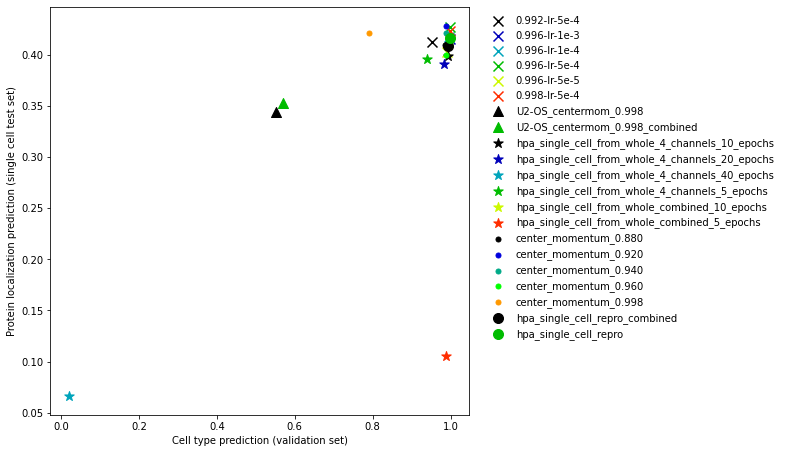

In [33]:
fig, ax = plt.subplots(1,1,figsize=(7.5,7.5))
lrs = ['0.992-lr-5e-4', '0.996-lr-1e-3', '0.996-lr-1e-4', '0.996-lr-5e-4',
       '0.996-lr-5e-5', '0.998-lr-5e-4']

groups = ['-lr-',
           'U2-OS',
           'from_whole',
           'center_momentum',
           'repro']
markers = {'-lr-' : 'x',
           'U2-OS' : '^',
           'from_whole' : '*',
           'center_momentum' : '.',
           'repro' : 'o'}
group_indices = [np.where(results.name.str.contains(groups[i]))[0] for i in range(len(groups))]
for indices, g in zip(group_indices, groups):
    for ind, i in enumerate(indices):
        plt.scatter(result_values[i,0],
                    result_values[i,1],
                    label=names[i],
                    color=cmap(float(ind) / len(indices)),
                    marker = markers[g],
                    s=100)
plt.legend(frameon=False, bbox_to_anchor=[1.75,1], loc='upper right')
plt.xlabel('Cell type prediction (validation set)')
plt.ylabel('Protein localization prediction (single cell test set)')


In [34]:
group_indices

[array([0, 1, 2, 3, 4, 5]),
 array([6, 7]),
 array([14, 15, 16, 17, 18, 19]),
 array([ 8,  9, 10, 11, 12]),
 array([13, 20])]

(0.98, 1.0, 0.39, 0.43)

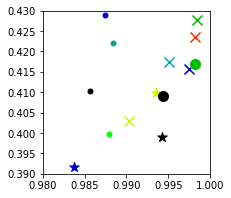

In [40]:
fig, ax = plt.subplots(1,1,figsize=(3,3))
for indices, g in zip(group_indices, groups):
    for ind, i in enumerate(indices):
        plt.scatter(result_values[i,0],
                    result_values[i,1],
                    label=names[i],
                    color=cmap(ind / len(indices)),
                    marker = markers[g],
                    s=100)
plt.axis([0.98, 1.0, 0.39, 0.43, ])


In [36]:
all_targets = torch.load('/scr/mdoron/Dino4Cells/results/without-norm-varied-masked-mom-0.960-epoch-100_vit_base_HPA/all_targets.pth')

In [37]:
all_predictions = torch.load('/scr/mdoron/Dino4Cells/results/without-norm-varied-masked-mom-0.960-epoch-100_vit_base_HPA/predictions.pth')

In [38]:
from sklearn.metrics import f1_score
f1_score(
    (torch.sigmoid(torch.stack(all_predictions)) > 0.5).int().squeeze(1),
    torch.stack(all_targets).squeeze(1),
    average='macro',
    zero_division=0)



0.4938977088162879